<a href="https://colab.research.google.com/github/AlexandreCandidoXavier/BR-DWGD/blob/main/notebooks/exemplo_google_earth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalhando com dados pontuais no Google Earth

OBS: versão atualizada do google earth engine.

Neste exemplo, para obtenção dos dados de um ponto,
não será necessário baixar os arquivos Netcdf. Estes serão adquiridos via a 
plataforma [Google Earth Engine](https://earthengine.google.com/)
Vamos trabalhar com a variável precipitação para uma posição geográfica, 
nos níveis de tempo: diário, mensal e anual.

Informações sobre o asset BR-DWGD no GEE [aqui](https://code.earthengine.google.com/?asset=projects/ee-alexandrexavier/assets/BR-DWGD)

Para rodar será necessário fazer uma cópia deste *notebook* no seu computador ou no seu 
*Google Drive*, se estiver utilizando o **Colab** (Menu File -> Save copy in Drive).

In [1]:
# instalando geemap atualizado (https://geemap.org/):
# %pip install -U geemap

In [128]:
import ee
import geemap
import numpy as np
import datetime
import pandas as pd
import plotly.express as px
import geemap.colormaps as cm

Vai pedir a autentificação (tem que ter conta gmail)

In [106]:
ee.Authenticate()

True

In [107]:
ee.Initialize(project='ee-alexandrexavier')

Pegando variável precipitação e reescalonando.

In [147]:
# variável
var_name = 'pr' # ('Rs', 'u2', 'Tmax', 'Tmin', 'RH', 'pr', 'ETo')

# definindo período (tem limite)
start_date, end_date = '2018-01-01','2024-03-22'

var = ee.ImageCollection('projects/ee-alexandrexavier/assets/BR-DWGD') \
                        .filterDate(start_date, end_date) \
                        .select(var_name)

In [148]:
var.first()

Ganhos e o
ffsets de cada uma das variáveis

In [149]:
# Informações gerais das bandas de escala e offset
BAND_Rs_MULT, BAND_Rs_ADD, BAND_Rs_UNIT = 0.15708661, -0.057087, 'MJ m-2'
BAND_u2_MULT, BAND_u2_ADD, BAND_u2_UNIT = 0.05905512, -0.059055, 'm s-1'
BAND_Tmax_MULT, BAND_Tmax_ADD, BAND_Tmax_UNIT = 0.00106815, 15.0, 'Celcius degrees'
BAND_Tmin_MULT, BAND_Tmin_ADD, BAND_Tmin_UNIT = 0.00106815, 15.0, 'Celcius degrees'
BAND_RH_MULT, BAND_RH_ADD, BAND_RH_UNIT = 0.39370079, -0.393701, '%'
BAND_pr_MULT, BAND_pr_ADD, BAND_pr_UNIT = 0.00686666, 225.0, 'mm'
BAND_ET_MULT, BAND_ET_ADD, BAND_ET_UNIT = 0.0511811, 0.0, 'mm'

Reescalonar

In [150]:
offset = BAND_pr_ADD
scale  = BAND_pr_MULT

# reescalonando
def scaleBand(image):
    scaledImage = image.select(var_name).multiply(scale).add(offset) \
                       .set({'date': image.date().format('yyyy-MM-dd')}) 
    return scaledImage.copyProperties(image, image.propertyNames())

var = var.map(scaleBand)

In [152]:
# informações para plotar o mapa da precipitação
vis = {'min': 0,'max': 40, 'palette': cm.palettes.jet}

Definindo coordenada de onde se quer obter os dados

In [153]:
# coordenada do ponto de interesse [lon, lat]
lon_lat = [-43.04, -14.33]
point = {'type': 'Point', 'coordinates': lon_lat}

m = geemap.Map()
m.addLayer(var.first(), vis, 'Precipitação')
m.addLayer(ee.Feature(point), {'color': 'red'}, "posição")
m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

Pegando informações para uma posição. Pode demorar um pouco se o intervalo de tempo for grande.

In [154]:
dados = var.getRegion(point, scale=10000).getInfo()

Criando dataframe

In [155]:
df = pd.DataFrame(dados[1:], columns=dados[0])
df.index = pd.to_datetime(df['id'].str.split('_').str[-1]).values
df.index.set_names('Data', inplace=True)
df

,id,longitude,latitude,time,pr
Data,,,,,
2018-01-01,BRDWGD_20180101,-43.074218,-14.328129,1514764800000,7.999811
2018-01-02,BRDWGD_20180102,-43.074218,-14.328129,1514851200000,2.856682
2018-01-03,BRDWGD_20180103,-43.074218,-14.328129,1514937600000,2.403483
2018-01-04,BRDWGD_20180104,-43.074218,-14.328129,1515024000000,1.291084
2018-01-05,BRDWGD_20180105,-43.074218,-14.328129,1515110400000,2.952816
...,...,...,...,...,...
2024-03-16,BRDWGD_20240316,-43.074218,-14.328129,1710547200000,0.000152
2024-03-17,BRDWGD_20240317,-43.074218,-14.328129,1710633600000,0.041352
2024-03-18,BRDWGD_20240318,-43.074218,-14.328129,1710720000000,0.267952


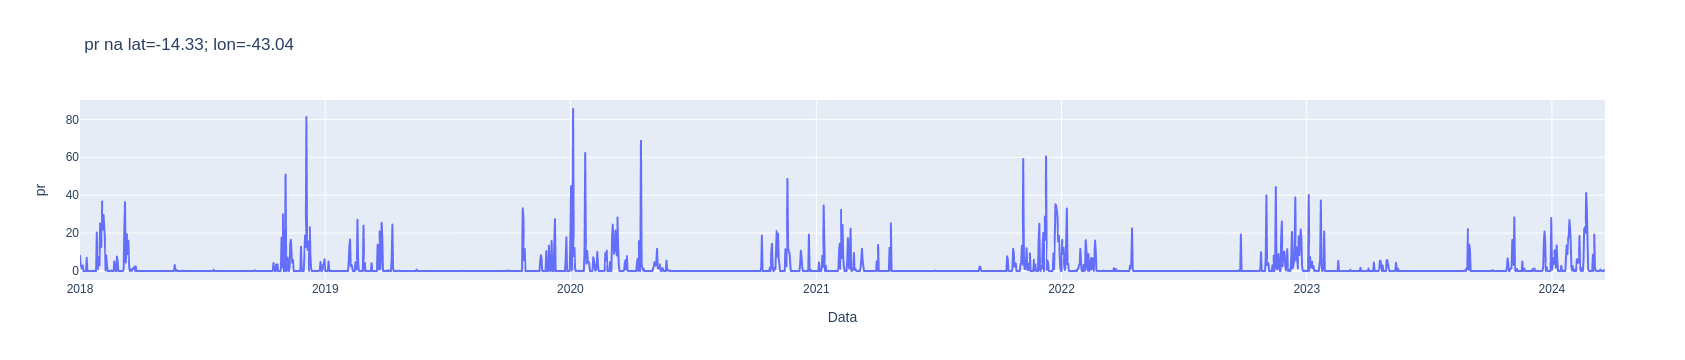

In [156]:
# plotando
fig = px.line(df, x=df.index, y=var_name,
              title=f"{var_name} na lat={lon_lat[1]}; lon={lon_lat[0]}")
fig.update_traces(hovertemplate="Data: %{x} <br> prec: %{y:.1f} mm ")
fig.show()

Para salvar dados em formato "csv"

In [15]:
# df.to_csv('dados.csv')

## Agregando dados diários para mensal e plotando

In [157]:
df_mes = df[var_name].resample('ME').sum()

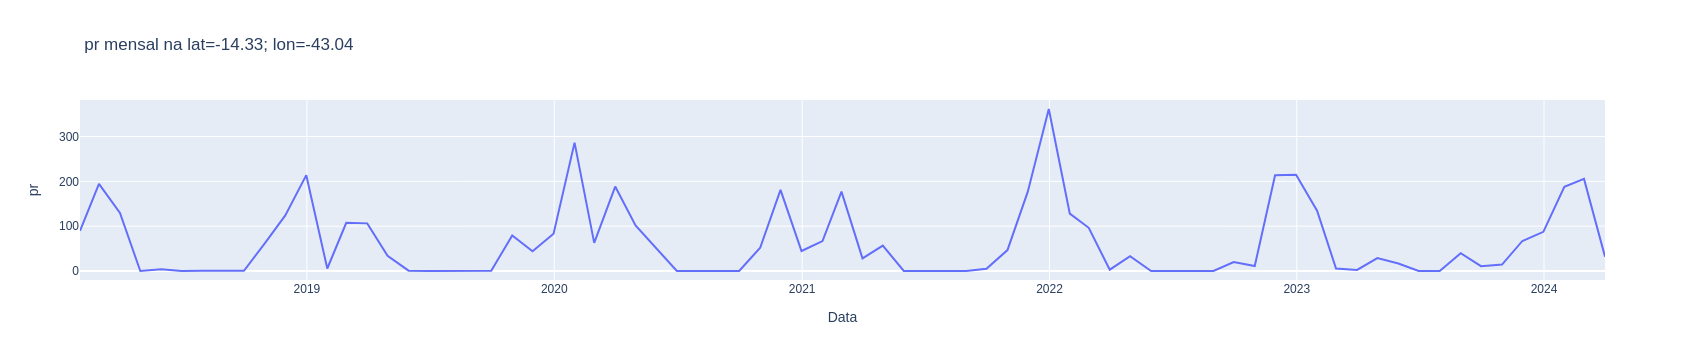

In [158]:
# Plotando mensal
fig = px.line(df_mes, x=df_mes.index, y=var_name,
              title=f"{var_name} mensal na lat={lon_lat[1]}; lon={lon_lat[0]}")
fig.update_traces(hovertemplate="Data: %{x} <br>prec: %{y:.1f} mm")
fig.show()

## Agregando dados diários para anual e plotando

In [159]:
df_ano = df[var_name].resample('YE').sum()
df_ano

Data
2018-12-31    819.247938
2019-12-31    460.698419
2020-12-31    966.242680
2021-12-31    919.508040
2022-12-31    720.292500
2023-12-31    407.145338
2024-12-31    425.230063
Freq: YE-DEC, Name: pr, dtype: float64

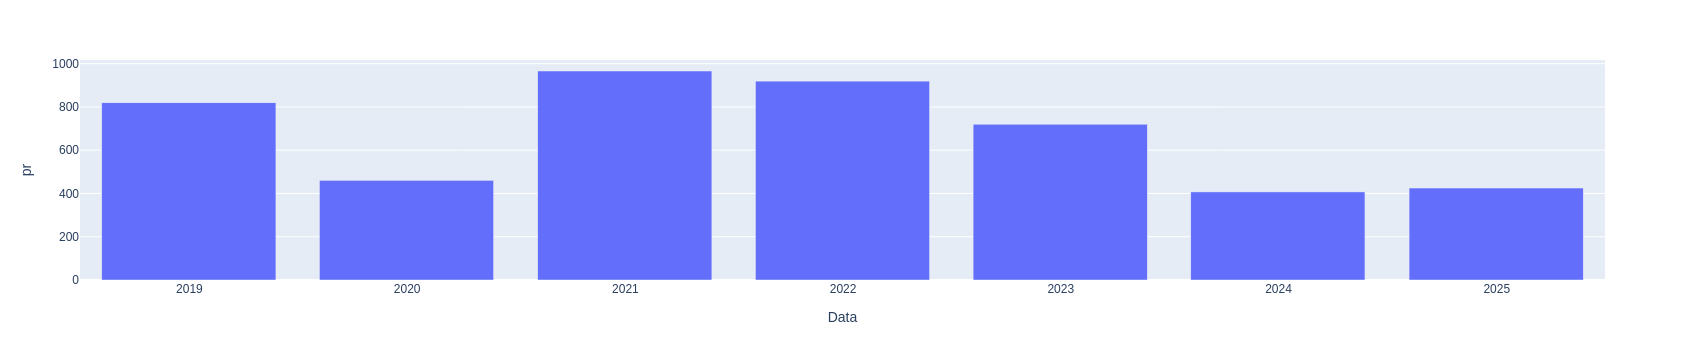

In [160]:
# plotando anual
fig = px.bar(df_ano, x=df_ano.index, y='pr')
fig.update_traces(hovertemplate="Data: %{x} <br>prec: %{y:.0f} mm")
fig.show()